In [2]:
import cv2
from scipy.signal import convolve2d
import numpy as np
import os
from scipy.sparse.linalg import svds
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.fft import dctn, idctn

In [34]:
from utils.fonctions import lightDirection, lightsDirection, getI

In [35]:
images = []

path = "./data/vase"

for image_path in os.listdir(path):
    image = cv2.imread(path + image_path)
    images.append(image)

In [36]:
images[0].shape

AttributeError: 'NoneType' object has no attribute 'shape'

In [11]:
S = lightsDirection(images, [350, 1760, 1975, 3315])

100%|██████████| 16/16 [01:39<00:00,  6.21s/it]


In [14]:
ratio = images[0].shape[1] / images[0].shape[0]

images2 = []
for image in images:
    i = cv2.resize(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY), (1000, int(1000 * ratio)))
    i = i[160:510, 290:860]
    images2.append(i)


In [15]:
I = getI(images2)

In [16]:
U, D, Vt = svds(I, k=3)
D = np.diag(D)

In [17]:
I = U @ D @ Vt

In [18]:
pseudo_inverse_S = np.linalg.pinv(S)

In [19]:
m = pseudo_inverse_S @ I

In [20]:
rho_estime = np.sqrt(np.sum(np.square(m), 0))

In [21]:
N_estime = m / rho_estime

In [22]:
indices = np.where(np.abs(N_estime[2, :]) < 0.1)
N_estime[0, indices] = np.inf

In [23]:
p_estime = -N_estime[0, :] / N_estime[2, :]
q_estime = N_estime[1, :] / N_estime[2, :]

In [24]:
n,m = images2[0].shape

In [25]:
p_estime = p_estime.reshape([n, m])
q_estime = q_estime.reshape([n, m])

In [26]:
rho_estime = rho_estime.reshape([n, m])

In [27]:
def integrationSCS(p, q, gt=None):
    # Compute div(p,q)

    print(q.shape)

    px = 0.5 * (np.roll(p, -1, axis=0) - np.roll(p, 1, axis=0))
    qy = 0.5 * (np.roll(q, -1, axis=1) - np.roll(q, 1, axis=1))

    # Div(p,q) + Boundary Condition
    f = px + qy
    f[0, 1:-1] = 0.5 * (p[0, 1:-1] + p[1, 1:-1])
    f[-1, 1:-1] = 0.5 * (-p[-1, 1:-1] - p[-2, 1:-1])
    f[1:-1, 0] = 0.5 * (q[1:-1, 0] + q[1:-1, 1])
    f[1:-1, -1] = 0.5 * (-q[1:-1, -1] - q[1:-1, -2])

    f[0, 0] = 0.5 * (p[0, 0] + p[1, 0] + q[0, 0] + q[0, 1])
    f[-1, 0] = 0.5 * (-p[-1, 0] - p[-2, 0] + q[-1, 0] + q[-1, 1])
    f[0, -1] = 0.5 * (p[0, -1] + p[1, -1] - q[0, -1] - q[0, -2])
    f[-1, -1] = 0.5 * (-p[-1, -1] - p[-2, -1] - q[-1, -1] - q[-1, -2])

    # Cosine Transform of f
    fsin = dctn(f, norm='ortho')

    # Denominator
    x, y = np.meshgrid(np.arange(p.shape[1]), np.arange(p.shape[0]))
    denom = (2 * np.cos(np.pi * x / p.shape[1]) - 2) + (2 * np.cos(np.pi * y / p.shape[0]) - 2)
    Z = fsin / denom
    Z[0, 0] = 0.5 * (Z[0, 1] + Z[1, 0])  # Or whatever...

    # Inverse Cosine Transform
    U = idctn(Z, norm='ortho')

    if gt is not None:
        moyenne_ecarts = np.mean(U - gt)
        U -= moyenne_ecarts
        npix = p.shape[0] * p.shape[1]
        rmse = np.sqrt(np.sum((U - gt) ** 2) / npix)
        return U, rmse
    else:
        U -= np.min(U)
        return U

In [28]:
z_estime = integrationSCS(q_estime, p_estime)

(350, 570)


C:\Users\geogeo\AppData\Local\Temp\ipykernel_12904\425744732.py:27: RuntimeWarning: divide by zero encountered in divide
  Z = fsin / denom


In [29]:
z_estime

array([[  0.        ,   0.49190022,   1.0088494 , ..., 200.64349713,
        201.02017025, 201.40194005],
       [  0.6050213 ,   1.10026204,   1.62370286, ..., 200.60388266,
        200.99123051, 201.3504981 ],
       [  1.21976413,   1.69634907,   2.21087977, ..., 200.49990645,
        200.91034256, 201.28513897],
       ...,
       [171.38295402, 171.56937839, 171.75468998, ..., 201.13853687,
        200.93837928, 200.79393536],
       [171.86520397, 172.05719321, 172.23676712, ..., 201.0060305 ,
        200.83117126, 200.6769451 ],
       [172.34031081, 172.54622251, 172.72223717, ..., 200.87390294,
        200.72763895, 200.54587324]])

C:\Users\geogeo\AppData\Local\Temp\ipykernel_12904\4064068830.py:1: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(z_estime), cmap='viridis')  # Utilisation de log pour mieux visualiser les différences


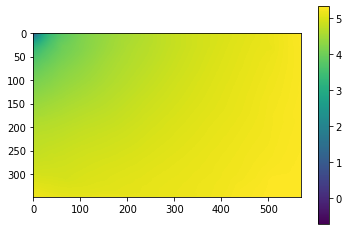

In [30]:
plt.imshow(np.log(z_estime), cmap='viridis')  # Utilisation de log pour mieux visualiser les différences
plt.colorbar()  # Ajout d'une barre de couleur pour indiquer l'échelle
plt.show()

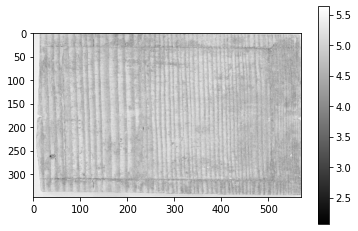

In [31]:
plt.imshow(np.log(rho_estime), cmap='gray')  # Utilisation de log pour mieux visualiser les différences
plt.colorbar()  # Ajout d'une barre de couleur pour indiquer l'échelle
plt.show()

In [32]:
nb_lignes, nb_colonnes = z_estime.shape

if z_estime[nb_lignes // 2, nb_colonnes // 2] < z_estime[1, 1]:
    z_estime = -z_estime

(350, 570) (350, 570) (350, 570)


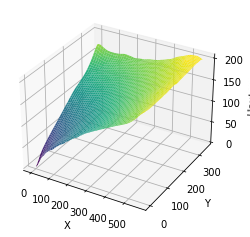

In [33]:
z = z_estime

# Création des coordonnées x et y pour chaque point de la matrice z
x, y = np.meshgrid(np.arange(z.shape[1]), np.arange(z.shape[0]))

print(x.shape, y.shape, z.shape)

# Création de la figure
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Affichage de la surface 3D
ax.plot_surface(x, y, z, cmap='viridis')

# Étiquetage des axes
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Hauteur')

# Affichage
plt.show()